In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

C:\Users\mkuzo\AppData\Local\Temp\ipykernel_14516\1918317977.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])


In [2]:
X_train = np.loadtxt(r"C:\Users\mkuzo\Downloads\UCI HAR Dataset\UCI HAR Dataset\train\X_train.txt")
y_train = np.loadtxt(r"C:\Users\mkuzo\Downloads\UCI HAR Dataset\UCI HAR Dataset\train\y_train.txt").astype(int)

X_test = np.loadtxt(r"C:\Users\mkuzo\Downloads\UCI HAR Dataset\UCI HAR Dataset\test\X_test.txt")
y_test = np.loadtxt(r"C:\Users\mkuzo\Downloads\UCI HAR Dataset\UCI HAR Dataset\test\y_test.txt").astype(int)

Часть 1

In [3]:
X_train.shape

(7352, 561)

In [4]:
X_test.shape

(2947, 561)

^ объединим по вертикальной оси

In [5]:
y_train.shape

(7352,)

In [6]:
y_test.shape

(2947,)

^ объединим по горизонтальной оси 

In [7]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [8]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

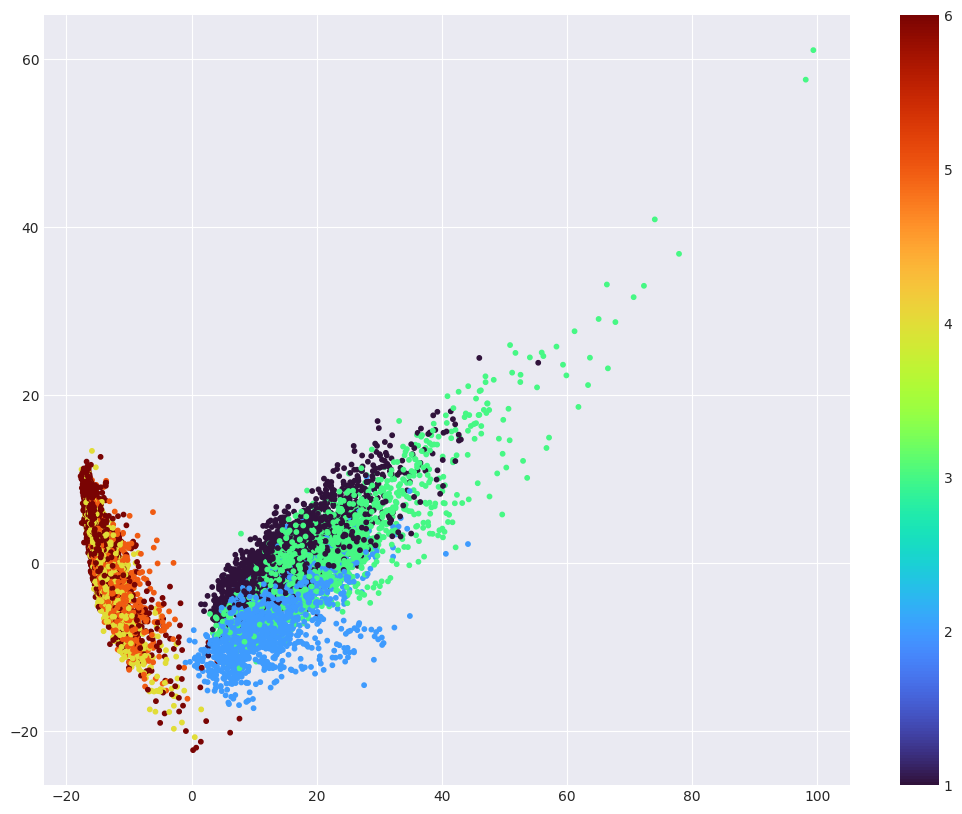

In [11]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10, cmap='turbo')
plt.colorbar()

In [12]:
km = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
km_predict = km.predict(X_pca)

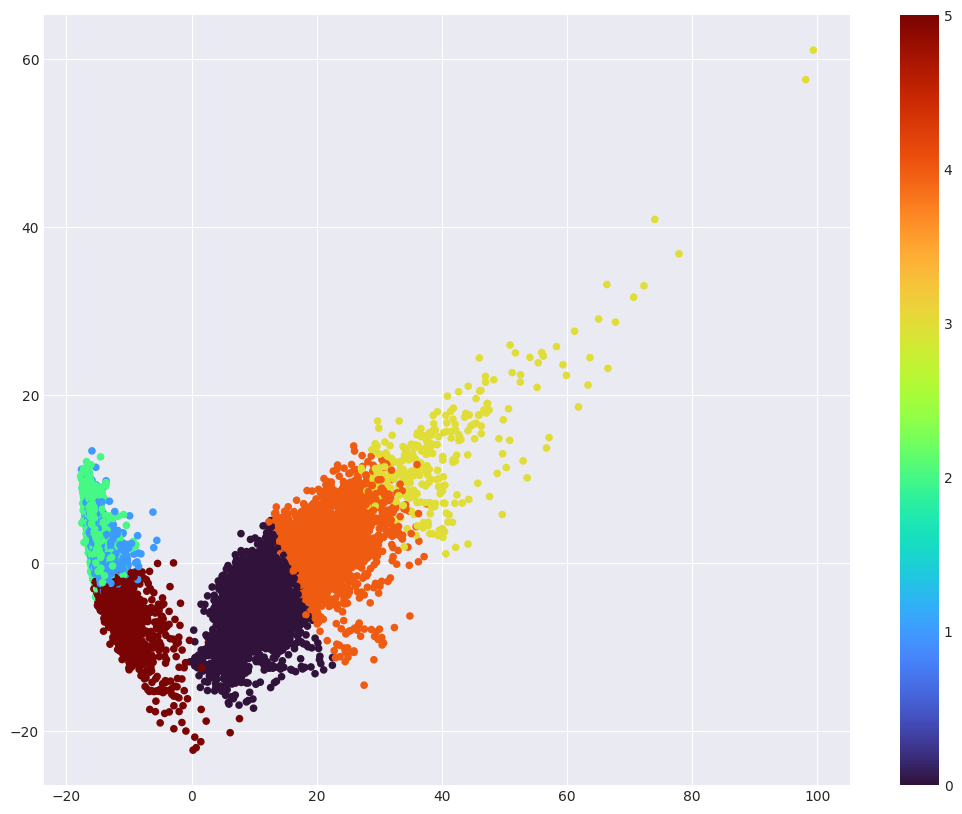

In [13]:
plt.figure(figsize=(13,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_predict, s=20,  cmap='turbo')
plt.colorbar()

In [14]:
labels = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

Homogeneity: 0.541
Completeness: 0.581
V-measure: 0.560
Adjusted Rand-Index: 0.420
Adjusted mutual info score: 0.560
Silhouette Coefficient: 0.146


In [15]:
ag = AgglomerativeClustering(n_clusters=6, 
                             linkage='ward').fit(X_pca)

In [16]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, ag.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, ag.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, ag.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, ag.labels_))
print("Adjusted mutual info score: %.3f"
      % metrics.adjusted_mutual_info_score(labels, ag.labels_))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, ag.labels_, sample_size=1000))


Homogeneity: 0.578
Completeness: 0.673
V-measure: 0.622
Adjusted Rand-Index: 0.494
Adjusted mutual info score: 0.622
Silhouette Coefficient: 0.151


Аггломератив кластеринг справляется с кластеризацией лучше (все оценки лучше)

Часть 2

In [17]:
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram

In [29]:
mergings = linkage(X_pca, method='complete')

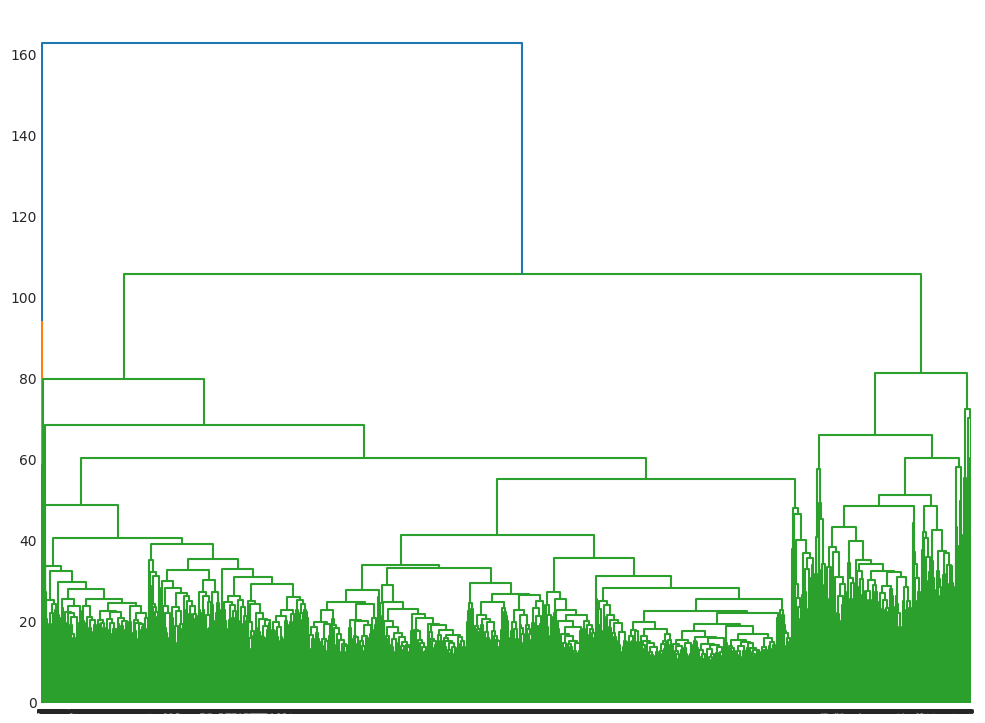

In [30]:
dendrogram(mergings,
           labels=y,
           leaf_rotation=90,
           leaf_font_size=6,
           )

plt.show()

://///////////// неудачненько

In [22]:
from sklearn.manifold import TSNE

In [23]:
model = TSNE(learning_rate=100)

In [31]:
transformed = model.fit_transform(X_pca)

In [32]:
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

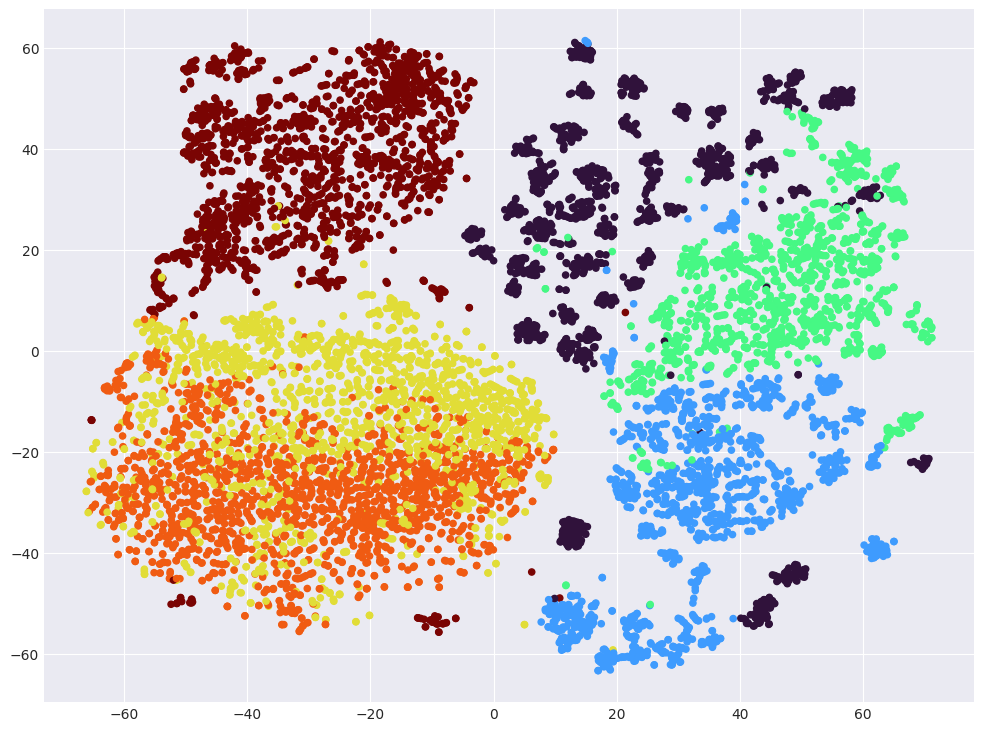

In [33]:
plt.scatter(x_axis, y_axis, c=y, s=20, cmap='turbo')
plt.show()

тоже мимо // Маша из будущего решила что это лучшее из худшего...

In [27]:
from sklearn.cluster import DBSCAN

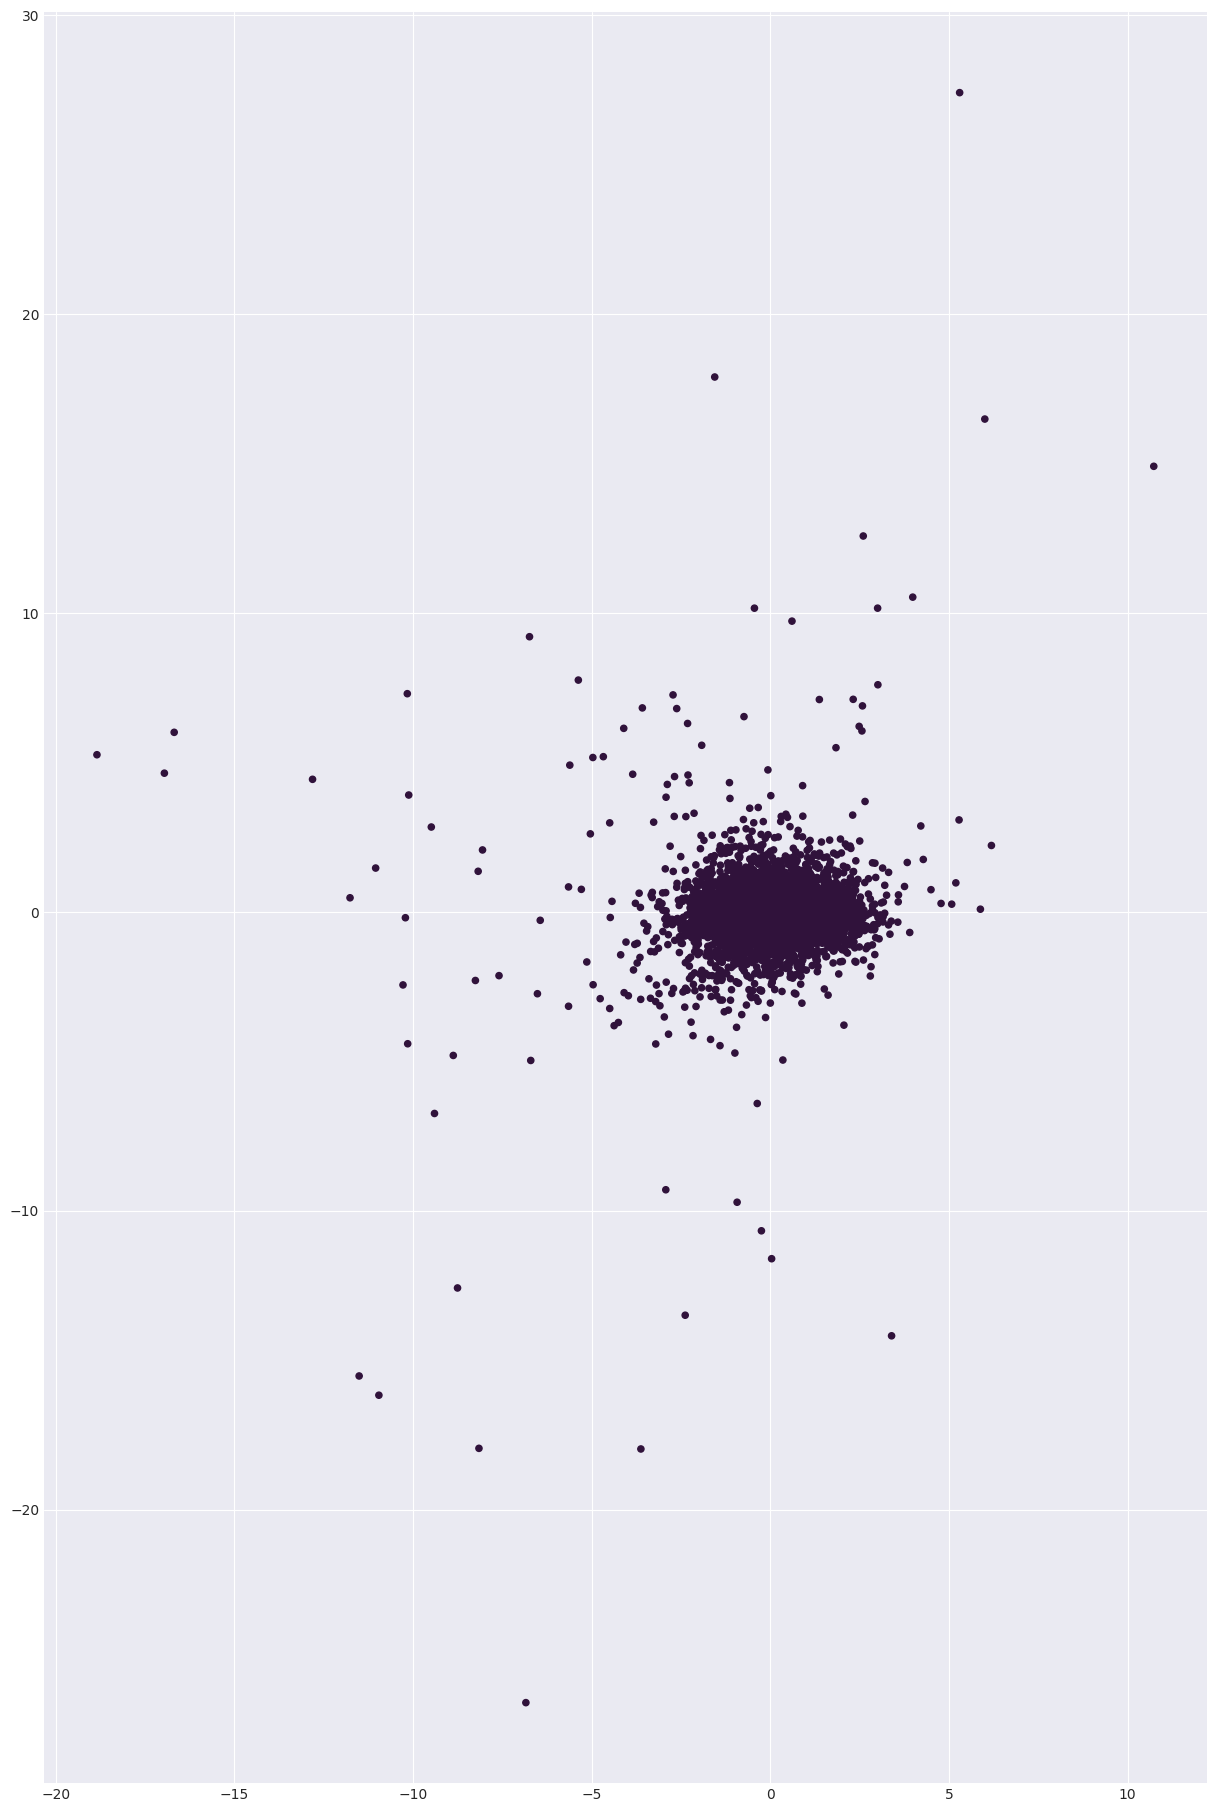

In [28]:
plt.figure(figsize= (15,23))
dbscan = DBSCAN(eps=0.036, min_samples=4)
clusters = dbscan.fit_predict(X_scaled)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c = clusters, s=20, cmap='turbo')

plt.show()

не получается...

| Самый лучший tsne кластеринг, но все равно там встречаются места, где сливаются несколько активностей  в одну кучку (по графику), а также очень много выбросов и шумов. Видимо, это может быть связано с фиксацией данных самого телефона (в кармане неправильно посчитал; человек сидел в машине, но быстро передвигался; телефон не трясся при хождении, был стабилен и т. д.) или добавлением каких-то данных самими пользователями (например, человек вышел на пробежку без телефона, а потом вернулся домой и внес данные о тренировке). Кластеризация в любом случае получается не очень качественная как раз из-за обилия несостыковок и выброса в данных